# Heat Equation in a Circle (Crank-Nicolson)

Variational Form:

$$
A_{n+1}(v, u; \Delta t) = \int_\Omega \left(v u_{n+1} + \frac{\Delta t}{2} \kappa \nabla v \cdot \nabla u_{n+1} 
\right) \, dx
$$

$$
F_n(v, u; \Delta t) = \int_\Omega \left(v u_n - \frac{\Delta t}{2}
\kappa \nabla v \cdot \nabla u_n \right) \, dx
$$

$$
\Omega = \left\{x \in \mathbb{R}^2 : ||x|| \leq 1\right\}
$$

Example:

$$
u(x, t=0) = u_0(x) = 1 - ||x||^2, \quad \kappa = 1, \quad t \in \left[0, T\right], \quad 
\Delta t = \frac{T}{N}
$$

In [13]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

tol = 1e-1
h = 0.5
R = 1
Ω = Cylinder(Point(0, 0, h), Point(0, 0, 0), R, R)

N = 50   # N is like 1 / Δx
mesh = generate_mesh(Ω, N)

V = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)

#bc = DirichletBC(V, Constant(1.0), "on_boundary")

def dirichlet_boundary(x, on_boundary):
    on_side = pow(x[0], 2) + pow(x[1], 2) > pow(R, 2) - tol and on_boundary
    on_bottom = abs(x[2]) < tol and on_boundary
    return on_side or on_bottom

bc = DirichletBC(V, Constant(0.0), dirichlet_boundary)

# time stepping
T = 0.1
N = 250
Δt = T / N

# initial condition
u_n = Function(V, name="solution")
u_n.assign(Constant(1.0))

# variational problem
A = (v * u + 0.5 * Δt * dot(grad(v), grad(u)) ) * dx
F = (v * u_n - 0.5 * Δt * dot(grad(v), grad(u_n)) ) * dx


u_next = Function(V)

usol = []
usol.append(u_n)
# saving to file
xdmfname = "heat-sol.xdmf"
fout = XDMFFile(xdmfname)
fout.parameters["flush_output"] = True
fout.parameters["functions_share_mesh"] = True
fout.parameters["rewrite_function_mesh"] = False

# solution
for n in range(N):
    solve(A == F, u_next, bc)
    u_n.assign(u_next)
    usol.append(u_n)
    fout.write(u_n, n * Δt)

## Heat Equation with Phase Change in cylinder

$$
\tilde \Omega = \{\tilde x \in \mathbb{R}^3 : \tilde x = (r\cos\theta, r\sin\theta, z), 
0 \leq r < R, 0 < z < H, 0 \leq \theta \leq 2\pi\}
$$

Let $S_2$ be the top surface ($z = H$), and $S_1 = \partial \tilde \Omega \setminus S_2$

$$
\frac{\partial \tilde T}{\partial \tilde t} = \tilde \nabla \cdot \left(
\tilde \kappa(\tilde T) \tilde \nabla \tilde T\right), \quad \tilde x \in \tilde \Omega, \quad 
\tilde T(\tilde x, 0) = T_c, \quad \tilde T = T_H, \quad \tilde x \in S_1, \quad 
\frac{\partial \tilde T}{\partial \tilde n} = 0, \quad \tilde x \in S_2
$$

With a heat conductivity dependent on temperature:

$$
\tilde\kappa (\tilde T) = \kappa_0 + \left(\frac{\kappa_1 - \kappa_0}{2}\right) \left[
1 + \tanh\left(\frac{\tilde T - T_*}{\mu}\right)\right]
$$

Nondimensionalize:

$$
u = \frac{\tilde T - T_H}{T_c - T_H}, \quad \kappa(u) = \frac{\tilde \kappa(\tilde T(u))}{\kappa_0} = 
1 - \frac{1 - k}{2}\left[1 - \tanh\left(\frac{u - \tau}{\eta}\right)\right]
$$

$$
k = \frac{\kappa_1}{\kappa_0}, \quad \tau = \frac{T_H - T_*}{T_H - T_c}. \quad 
\eta = \frac{\mu}{T_H - T_c}
$$

$$
\tilde x = R x, \quad \tilde t = \frac{R^2}{\kappa_0} t
$$

$$
\Omega = \{x \in \mathbb{R}^3 : x = (r\cos\theta, r\sin\theta, z), 0 \leq r < 1, \quad 
0 < z < h\}, \quad h = \frac{H}{R}
$$

$$
\frac{\partial u}{\partial t} = \nabla \cdot \left(\kappa(u) \nabla u\right), \quad x \in \Omega, \quad 
u(x, 0) = 1, \quad u = 0, \quad x \in S_1, \quad \frac{\partial u}{\partial n} = 0, \quad x \in S_2
$$

Controlling parameters:

$$
h, k (< 1), \tau (< 1), \eta
$$

FEniCS implementation

Crank-Nicolson time discritization:

$$
\frac{\partial u}{\partial t} = F(u) \implies \frac{u_{n+1} - u_n}{\Delta t} = \frac{1}{2} \left(
F(u_{n+1}) + F(u_n)\right)
$$

$$
u_{n+1} - \frac{\Delta t}{2} F(u_{n+1}) = u_n + \frac{\Delta t}{2} F(u_n)
$$

Variational form:

$$
\left\langle u_{n+1}, v\right\rangle - \frac{\Delta t}{2} \left\langle F(u_{n+1}), v\right\rangle = 
\left\langle u_n, v\right\rangle + \frac{\Delta t}{2} \left\langle F(u_n), v\right\rangle, \quad 
\left\langle u, v\right\rangle = \int_\Omega u v \, dx
$$

$$
\left\langle F(u), v\right\rangle = \int_\Omega v \nabla \cdot \left(\kappa (u) \nabla u\right) \, dx = 
\int_{\partial \Omega} v \kappa (u) \frac{\partial u}{\partial n} \, ds - 
\int_\Omega \kappa (u) \nabla v \cdot \nabla u \, dx
$$

Since $v = 0$ on $S_1$ (the Dirichlet boundary), and $\frac{\partial u}{\partial n} = 0$ on $S_2$ (the 
Neumann boundary), then the boundary term vanishes giving

$$
\left\langle F(u), v\right\rangle = -\int_\Omega \kappa(u) \nabla v \cdot \nabla u \, dx =: 
\left\langle \kappa (u) \nabla u, \nabla v\right\rangle
$$

With the Crank-Nicolson time discretization, this gives 

$$
\left\langle u_{n+1}, v\right\rangle + \frac{\Delta t}{2} \left\langle \kappa (u_{n+1}) \nabla u_{n+1}, 
\nabla v\right\rangle = \left\langle u_n, v\right\rangle - \frac{\Delta t}{2} \left\langle 
\kappa(u_n) \nabla u_n, \nabla v\right\rangle
$$

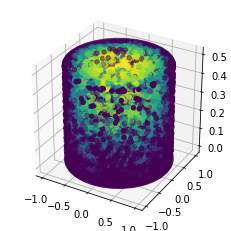

In [12]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from fenics import *
from mshr import *
from ufl import tanh

# tolerance value for boundaries
tol = 1e-1

# parameters
h = 0.5   # ratio of height to radius
k = 0.1   # ratio of cooked heat diffusivity to raw diffusivity
τ = 0.6   # (T_H - T*) / (T_H - T_c)
η = 0.5   # rate of cooking at temperature



# convert parameters to function like
h = Constant(h)
k = Constant(k)
τ = Constant(τ)
η = Constant(η)

# def tanh(X):
#     num = exp(X) - exp(-X)
#     den = exp(X) + exp(-X)
#     return num / den 

# build heat capacity from temperature
def κ(u):
    κ_val = 1 - (1 - k) / 2 * (1 - tanh((u - τ) / η))
    return κ_val

# time discretization
Tmax = 0.1
Nt = 250
Δt = Constant(Tmax / Nt)

# domain
R = 1.0
N = 50
Ω = Cylinder(Point(0, 0, h), Point(0, 0, 0), R, R)
mesh = generate_mesh(Ω, N)

# function space
V = FunctionSpace(mesh, "CG", 1)

# boundary condition
def dirichlet_boundary(x, on_boundary):
    on_side = abs(pow(x[0], 2) + pow(x[1], 2) - pow(R, 2)) < tol and on_boundary
    on_bottom = abs(x[2]) < tol and on_boundary
    return on_side or on_bottom

bc = DirichletBC(V, Constant(0.0), dirichlet_boundary)
    
# variational form
u_prev = Function(V, name="solution")

#κ = Expression("1 - (1 - k) / 2 * (1 - tanh(u - T) / n)", degree=2, k=k, T=τ, n=η, u=u_prev)


#u = TrialFunction(V)
u = Function(V)
v = TestFunction(V)

L = (u_prev * v) * dx - Constant(0.5) * Δt * κ(u_prev) * dot(grad(u_prev), grad(v)) * dx
A = (u * v) * dx + Constant(0.5) * Δt * κ(u) * dot(grad(u), grad(v)) * dx
F = A - L


# initial condition
u_init = interpolate(Constant(1.0), V)
u_prev.assign(u_init)

t = np.linspace(0, Tmax, Nt+1)
u_sols = []
u_sols.append(u_prev)

# filename for storing solution
xdmfname = "heat-nonlin-sol.xdmf"
fout = XDMFFile(xdmfname)
fout.parameters["flush_output"] = True
fout.parameters["functions_share_mesh"] = True
fout.parameters["rewrite_function_mesh"] = False

# time stepping
for n in range(Nt):
    #u_next = Function(V)
    solve(F==0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})
    u_prev.assign(u)
    u_sols.append(u_prev)
    fout.write(u_prev, t[n])
    #κ.u = u_prev
    
plot(u_sols[-1])
plt.show()



Plot of $\kappa(u)$

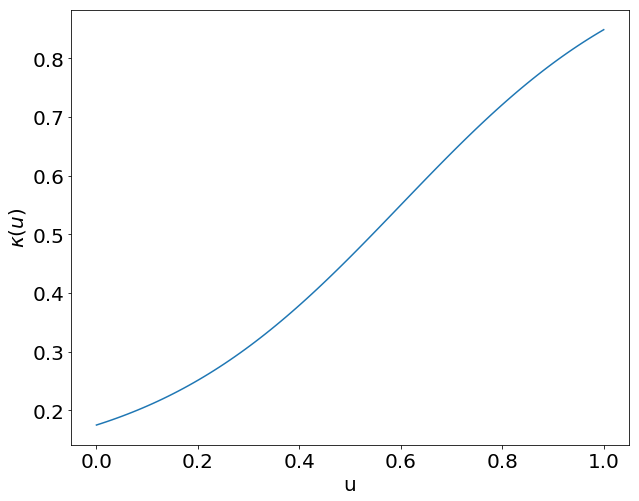

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size":20})

h = 0.5   # ratio of height to radius
k = 0.1   # ratio of cooked heat diffusivity to raw diffusivity
τ = 0.6   # (T_H - T*) / (T_H - T_c)
η = 0.5   # rate of cooking at temperature

uvals = np.linspace(0, 1, 100)
κ = lambda u: 1 - (1 - k) / 2 * (1 - np.tanh((u - τ) / η))

plt.figure(figsize=(10, 8))
plt.plot(uvals, κ(uvals))
plt.xlabel("u")
plt.ylabel("$\\kappa(u)$")
plt.savefig("kappa-u.eps")
plt.show()